# Fall Detection: A deep learning approach

## 1. Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# import the libraries and change the directory
import os
os.chdir('/content/drive/MyDrive/fall_detection/src/')

import numpy as np
import pandas as pd
pd.options.display.float_format = "{:,.3f}".format
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(context='paper', style='ticks')

from scipy import stats

from utils.utils import (load_df, load_data, analyze_metrics, analyze_errors,
                         get_results, open_results, model_confusion)

## 2. Loading the Data

First we load the dataframe from the data files using a Python script. For this project we only use the sensor data provided from the wrist sensors.

In [3]:
# load the dataframe
df = load_df(sensors=None)
df.head()

Acc  \
SubjectID ActivityID TrialNo Device                                                      
15        1          3       Wrist   [[3829, -796, -896], [3827, -797, -897], [3825...   
          2          2       Wrist   [[3801, -806, -1051], [3799, -802, -1051], [37...   
                     4       Wrist   [[3853, -821, -929], [3846, -822, -931], [3843...   
          3          1       Wrist   [[3859, -871, -958], [3860, -871, -956], [3859...   
          1          1       Wrist   [[3857, -884, -964], [3856, -885, -969], [3856...   

                                                                                   Gyr  \
SubjectID ActivityID TrialNo Device                                                      
15        1          3       Wrist   [[38, 28, 14], [41, 25, 13], [46, 25, 12], [50...   
          2          2       Wrist   [[-36, 76, -49], [-41, 79, -48], [-45, 81, -47...   
                     4       Wrist   [[-17, 31, 0], [-19, 28, 4], [-18, 29, 3], [-1...   
          3          1       Wrist   [[8, 23, 14], [8, 21, 13], [7, 21, 14], [2, 19...   
          1          1       Wrist   [[48, 16, 23], [49, 19, 23], [49, 20, 24], [47...   

                                                                                   Mag  \
SubjectID ActivityID TrialNo Device                                                      
15        1          3       Wrist   [[3245, -3, 7143], [3203, 29, 7078], [3236, 67...   
          2          2       Wrist   [[3282, 69, 7114], [3256, 88, 6962], [3268, 12...   
                     4       Wrist   [[3321, 124, 6879], [3277, 92, 7000], [3281, 7...   
          3          1       Wrist   [[3243, 93, 6863], [3257, 110, 6953], [3267, 6...   
          1          1       Wrist   [[3336, 90, 6950], [3333, 72, 6790], [3338, 92...   

                                                                                   Bar  
SubjectID ActivityID TrialNo Device                                                     
15        1          3       Wrist   [[991.6140978985547, 28.48333775043487], [991....  
          2          2       Wrist   [[991.6976868289529, 28.22778074264527], [991....  
                     4       Wrist   [[991.6402114111598, 28.48145766735077], [991....  
          3          1       Wrist   [[991.5897703292296, 28.19951235055924], [991....  
          1          1       Wrist   [[991.695918675455, 28.18796326875687], [991.7...

The data Includes the subject IDs, Trial Numbers, and the respective activities and sensor data. The sensors used were the accelerometer, gyroscope, magnetometer and barometer.

## 3. EDA

In [4]:
# some crude numbers about the data
len_df = len(df)
n_subjects = len(np.unique(df.index.get_level_values(0)))
n_activities = len(np.unique(df.index.get_level_values(1)))

print(f'- The data includes {len_df} observations/instances.')
print(f'- The number of subjects who participated in the experiments are {n_subjects}.')
print(f'- The number of activities recorded is {n_activities}.')

- The data includes 2515 observations/instances.
- The number of subjects who participated in the experiments are 13.
- The number of activities recorded is 79.


In [5]:
# more information on the sensor data
for col in df.columns:
    axes = df.reset_index(drop=True).loc[0, col].shape[1]
    len_sensor = df.reset_index(drop=True).loc[0, col].shape[0]

    print(f'- {col} sensor is {len_sensor} long and has {axes} axes')

- Acc sensor is 4760 long and has 3 axes
- Gyr sensor is 4760 long and has 3 axes
- Mag sensor is 1600 long and has 3 axes
- Bar sensor is 200 long and has 2 axes


The data contains sensor readings from a wrist wearable device and activity labels for 13 participants/subjects with 79 activities recorded over 2515 trials. The activities recorded include falls and ADLs.

The sensor readings contain the following:

- Triaxial Accelerometer: frequency 238 Hz
- Triaxial Gyroscope: frequency 238 Hz
- Triaxial Magnetometer: frequency 80 Hz
- Barometer measuring air pressure and temperature: frequency 10 Hz

The activities are recorded over a 20 seconds span for all sensors with the different frequencies.

In [6]:
activities = df.index.get_level_values(1)
falls = np.where(activities > 100, activities, 0)
adls = np.where(activities < 100, activities, 0)

n_falls = np.sum(np.where(falls != 0, 1, 0))
n_adls = np.sum(np.where(adls != 0, 1, 0))

print(f'The number of falls recorded is {n_falls}.')
print(f'The number of activities recorded is {n_adls}.')

unique_falls = np.unique(falls[falls != 0])
unique_adls = np.unique(adls[adls != 0])

print(f'The number of fall types recorded is {len(unique_falls)}.')
print(f'The number of daily activities recorded is {len(unique_adls)}.')

The number of falls recorded is 523.
The number of activities recorded is 1992.
The number of fall types recorded is 35.
The number of daily activities recorded is 44.


In [7]:
# some sensor readings statistics (need to figure out the scaling for sensors)
signals = {}

for col in df.columns:
    sen = np.vstack(df[col])
    sen_mean = np.mean(sen, axis=0)
    sen_std = np.std(sen, axis=0)
    sen_min = np.min(sen, axis=0)
    sen_max = np.max(sen, axis=0)
    signals[col] = [sen_mean, sen_std, sen_min, sen_max]

for k, v in signals.items():
    print(f'{k} sensor descriptive statistics:')
    if k != 'Bar':
        if k.startswith('Acc') or k.startswith('Mag'):
            display(pd.DataFrame(v, index=['mean', 'std', 'min', 'max'],
                                 columns=[f'{k}_x', f'{k}_y', f'{k}_z']) / 10000)
        else:
            display(pd.DataFrame(v, index=['mean', 'std', 'min', 'max'],
                                 columns=[f'{k}_x', f'{k}_y', f'{k}_z']) / 10)

    else:
        display(pd.DataFrame(v, index=['mean', 'std', 'min', 'max'],
                           columns=[f'{k}_pressure', f'{k}_temp']))
    print('\n')

Acc sensor descriptive statistics:


,Acc_x,Acc_y,Acc_z
mean,0.211,-0.024,-0.075
std,0.262,0.240,0.162
min,-3.153,-3.172,-3.174
max,3.268,3.202,3.131




Gyr sensor descriptive statistics:


,Gyr_x,Gyr_y,Gyr_z
mean,2.302,1.727,2.752
std,82.878,63.295,84.380
min,"-2,601.600","-1,659.400","-2,547.200"
max,"2,866.800","1,341.700","1,915.500"




Mag sensor descriptive statistics:


,Mag_x,Mag_y,Mag_z
mean,0.108,0.005,0.538
std,0.145,0.147,0.209
min,-0.419,-0.577,-0.573
max,0.779,0.620,1.492




Bar sensor descriptive statistics:


,Bar_pressure,Bar_temp
mean,"1,012.594",28.475
std,9.144,2.009
min,989.988,18.318
max,"1,026.880",33.805


The sensor readings values have very high ranges and variation except for the barometer readings.

In [8]:
# number of subjects by type of activity
df_falls = df[activities > 100]
df_adls = df[activities < 100]

subjects_falls = np.unique(df_falls.index.get_level_values(0))
subjects_adls = np.unique(df_adls.index.get_level_values(0))


print(f'The number of unique subjects who performed fall activities is {len(subjects_falls)}.')
print(f'The number of unique subjects who performed ADL activities is {len(subjects_adls)}.')

The number of unique subjects who performed fall activities is 9.
The number of unique subjects who performed ADL activities is 13.


The total number of trials recorded is 2515 with 523 falls and 1992 daily activities. 35 types of falls were recorded considering pre-fall status, reason of fall, fall direction, rotation and recovery. 44 types of daily activities were recorded between cyclic and transient movements.

9 subjects performed falls and 13 subjects performed ADLs.

## 4. Data Visualization

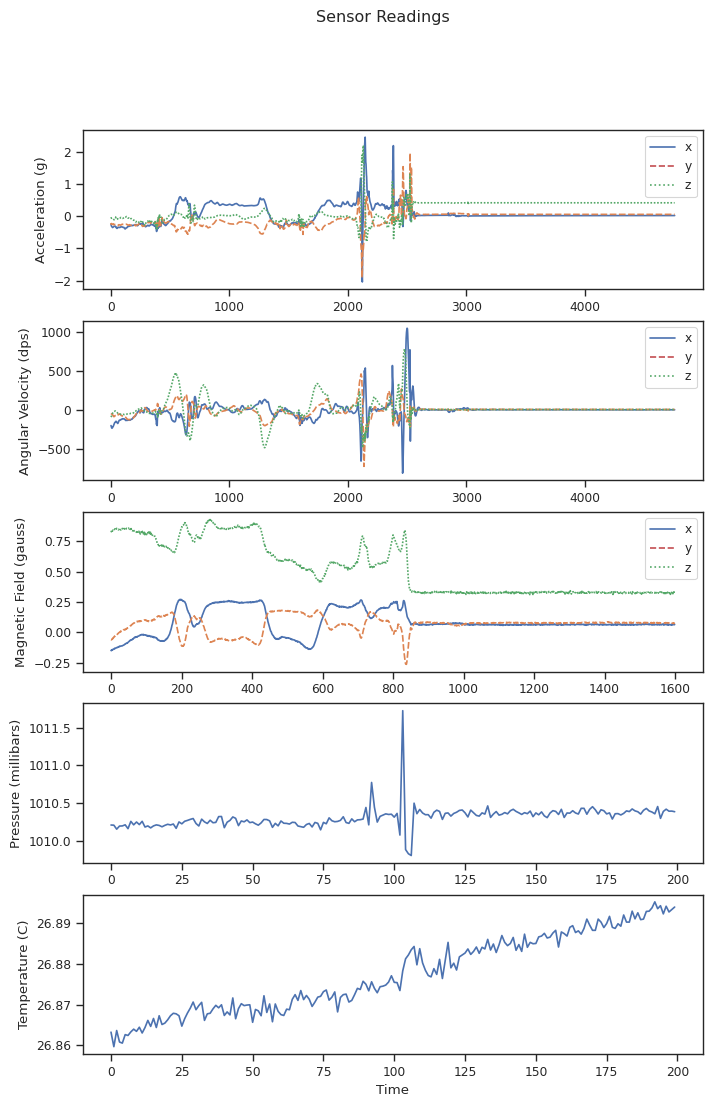

In [9]:
from matplotlib.lines import Line2D

# data visualization (need to figure out the scaling for sensors)
fig, axes = plt.subplots(nrows=5, figsize=(8, 12))

sns.lineplot(data=df_falls.reset_index(drop=True).iloc[0, 0] / 10000, ax=axes[0])
sns.lineplot(data=df_falls.reset_index(drop=True).iloc[0, 1] / 10, ax=axes[1])
sns.lineplot(data=df_falls.reset_index(drop=True).iloc[0, 2] / 10000, ax=axes[2])
sns.lineplot(data=df_falls.reset_index(drop=True).iloc[0, 3][:, 0], ax=axes[3])
sns.lineplot(data=df_falls.reset_index(drop=True).iloc[0, 3][:, 1], ax=axes[4])
fig.suptitle('Sensor Readings')
plt.xlabel('Time')
axes[0].set_ylabel('Acceleration (g)')
axes[1].set_ylabel('Angular Velocity (dps)')
axes[2].set_ylabel('Magnetic Field (gauss)')
axes[3].set_ylabel('Pressure (millibars)')
axes[4].set_ylabel('Temperature (C)')
for ax in axes[:3]:
    ax.legend(labels=('x', 'y', 'z'), handles=[Line2D([], []), Line2D([], [], linestyle='--', color='r'), Line2D([], [], linestyle=':', color='g')])
plt.show()

## 5. Results

### 1. Model Comparison

We trained 6 state-of-the-art (SOTA) time series classification (TSC) models and compared their accuracies on the FallAllD dataset.

In [10]:
compare_models = analyze_metrics(
    {'FCN': 'fcn/results.pkl',
     'ResNet': 'resnet/results.pkl',
     'InceptionTime': 'inception/results.pkl',
     'LSTM-FCN': 'lstmfcn/results.pkl',
     'ROCKET': 'rocket/results.pkl',
     'MINIROCKET': 'minirocket/results.pkl'},
    scoring='accuracy'
    )

In [11]:
compare_models

,FCN,ResNet,InceptionTime,LSTM-FCN,ROCKET,MINIROCKET
Subject_ID,,,,,,
1,84.322,79.237,92.797,87.712,88.559,87.288
2,91.213,88.703,89.958,86.192,90.795,99.582
3,86.364,84.711,92.149,83.884,94.215,94.628
4,60.185,63.889,68.519,84.259,80.556,92.593
5,80.556,85.185,91.667,87.037,93.981,88.426
6,81.197,77.350,84.615,77.778,89.316,88.889
9,89.450,94.037,94.954,87.615,92.202,96.330
10,99.371,96.226,99.371,98.113,99.371,98.113
11,100.000,100.000,100.000,96.774,95.484,99.355


In [12]:
compare_models.describe().loc[['mean', 'std']].T

,mean,std
FCN,88.587,11.069
ResNet,88.193,10.313
InceptionTime,91.791,8.302
LSTM-FCN,89.687,6.494
ROCKET,92.325,4.931
MINIROCKET,95.394,4.634


From the table and descriptive statistics we can see that the best performing model on the fall detection task is MINIROCKET with a mean accuracy of 95.4% across samples and 4.6% average standard deviation.

In [13]:
# friedman test
stats.friedmanchisquare(*compare_models.T.values)

FriedmanchisquareResult(statistic=15.929411764705879, pvalue=0.007048522935526997)

We hypothesize that the results of the models come from the same distribution and we test our hypothesis using friedman test. The result is a p-value = 0.007 which is smaller than 0.05. We conclude that the accuracies of the models on the different samples come from a different distribution compared to one another.

In [14]:
# Pairwise Wilcoxon signed-rank tests for post-hoc analysis
pairwise_comparisons = [
    ('FCN', 'ResNet'),
    ('FCN', 'InceptionTime'),
    ('FCN', 'LSTM-FCN'),
    ('FCN', 'ROCKET'),
    ('FCN', 'MINIROCKET'),
    ('ResNet', 'InceptionTime'),
    ('ResNet', 'LSTM-FCN'),
    ('ResNet', 'ROCKET'),
    ('ResNet', 'MINIROCKET'),
    ('InceptionTime', 'LSTM-FCN'),
    ('InceptionTime', 'ROCKET'),
    ('InceptionTime', 'MINIROCKET'),
    ('LSTM-FCN', 'ROCKET'),
    ('LSTM-FCN', 'MINIROCKET'),
    ('ROCKET', 'MINIROCKET')
]

wilcoxon_posthoc_results = {}
for model1, model2 in pairwise_comparisons:
    _, p = stats.wilcoxon(compare_models[model1], compare_models[model2], method='exact')
    wilcoxon_posthoc_results[(model1, model2)] = p

wilcoxon_post_hoc_df = pd.DataFrame(
    data=wilcoxon_posthoc_results.values(),
    index=wilcoxon_posthoc_results.keys(),
    columns=['p_value']).sort_values('p_value') \
    .reset_index() \
    .rename(columns={
        'level_0': 'Model_1',
        'level_1': 'Model_2'})
holms_correction = []
for row, label in wilcoxon_post_hoc_df.iterrows():
    holms_correction.append('Reject' if label['p_value'] * (15 - row) < 0.05 else 'Accept')
wilcoxon_post_hoc_df["H0 (Holm)"] = holms_correction
wilcoxon_post_hoc_df

/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


,Model_1,Model_2,p_value,H0 (Holm)
0,ResNet,MINIROCKET,0.004,Accept
1,LSTM-FCN,MINIROCKET,0.004,Accept
2,FCN,MINIROCKET,0.010,Accept
3,ResNet,InceptionTime,0.016,Accept
4,FCN,InceptionTime,0.047,Accept
5,ROCKET,MINIROCKET,0.068,Accept
6,InceptionTime,MINIROCKET,0.084,Accept
7,ResNet,ROCKET,0.094,Accept
8,InceptionTime,LSTM-FCN,0.117,Accept
9,FCN,ROCKET,0.136,Accept


For further testing, we perform a pair-wise wilcoxon signed rank test with holm's correction. From the results, we find that none of the models have a significant different accuracy.

<Axes: >

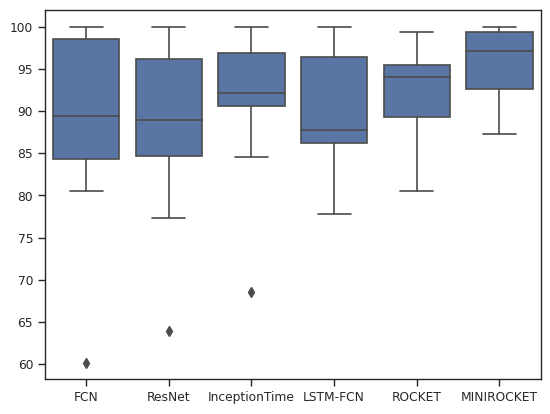

In [15]:
sns.boxplot(data=compare_models, color='b')

In [16]:
pd.DataFrame(data={
    'Accuracy': analyze_metrics({'score': 'minirocket/results.pkl'}, scoring='accuracy')['score'].values,
    'Balanced Accuracy': analyze_metrics({'score': 'minirocket/results.pkl'}, scoring='balanced_accuracy')['score'].values,
    'Precision': analyze_metrics({'score': 'minirocket/results.pkl'}, scoring='precision')['score'].values,
    'Recall': analyze_metrics({'score': 'minirocket/results.pkl'}, scoring='recall')['score'].values,
    'Specificity': analyze_metrics({'score': 'minirocket/results.pkl'}, scoring='specificity')['score'].values,
    'F1 Score': analyze_metrics({'score': 'minirocket/results.pkl'}, scoring='f1')['score'].values}).replace(0, np.nan).mean() # we replace 0 by nan because it's caused by a non existing class

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Accuracy            95.394
Balanced Accuracy   94.011
Precision           91.817
Recall              88.285
Specificity         96.898
F1 Score            89.041
dtype: float64

### 2. Error Analysis

In this last section we observe the errors made by the model and focus on the false negative and false positive results to find out the most confused activities and falls types.

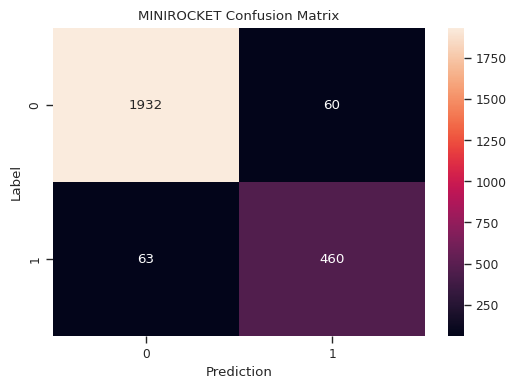

In [17]:
model_confusion('minirocket/results.pkl', 'MINIROCKET')

From the confusion matrix, it is evident that MINIROCKET prioritizes negative labels over positive labels due to the unbalanced dataset. However, this is not a big problem given the model's high accuracy, sensitivity and specificity. Which means the model can detect the positive and negative samples correctly with high efficacy and can be used in real world applications due to its excellent performance.

In [18]:
minirocket_labels, minirocket_true, minirocket_pred = get_results(open_results('minirocket/results.pkl'))
minirocket_fn, minirocket_fp = analyze_errors(minirocket_labels, minirocket_true, minirocket_pred)

In [19]:
fall_labels, fall_counts = np.unique(minirocket_fn, return_counts=True)
ind = np.argsort(fall_counts)
sorted_fall_labels = np.flip(np.take_along_axis(fall_labels, ind, axis=0))

act_labels, act_counts = np.unique(minirocket_fp, return_counts=True)
ind = np.argsort(act_counts)
sorted_act_labels = np.flip(np.take_along_axis(act_labels, ind, axis=0))

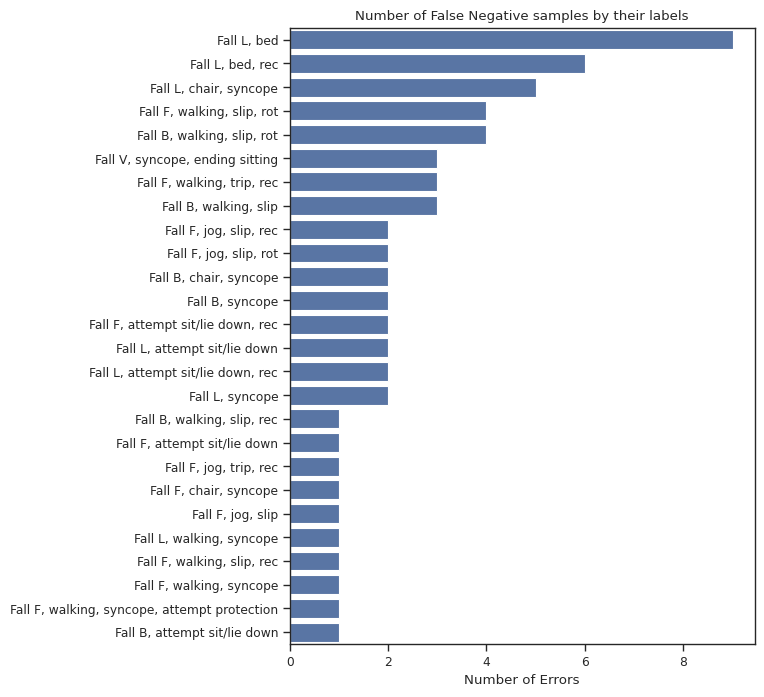

In [20]:
fig, ax = plt.subplots(figsize=(6, 8))
sns.countplot(y=minirocket_fn, color='b', ax=ax, order=sorted_fall_labels)
plt.title('Number of False Negative samples by their labels')
plt.xlabel('Number of Errors')

plt.show()

We found that the most confused falls for the model are:
1. Falling backwards due to slipping with and without rotation or with and without recovery
2. The model also confuses lateral falls and resting on the bed, and falling forward while walking due to slipping with rotation.

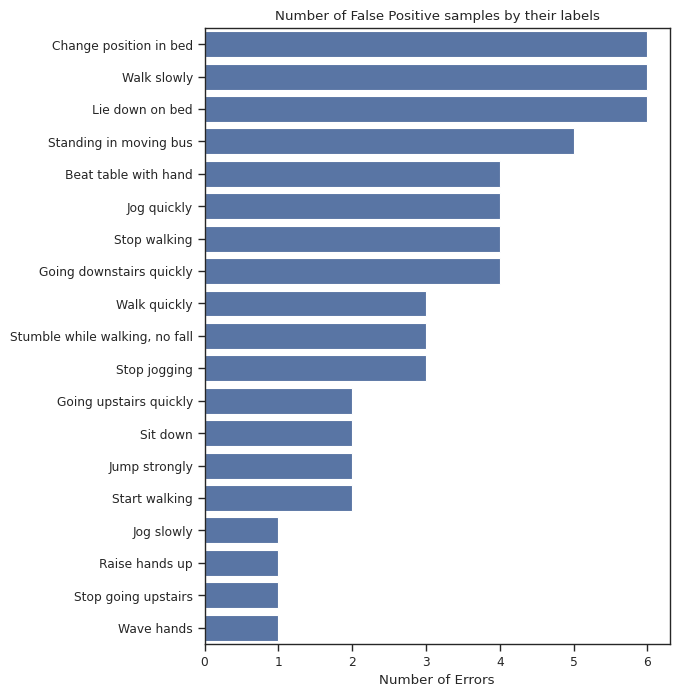

In [21]:
fig, ax = plt.subplots(figsize=(6, 8))
sns.countplot(y=minirocket_fp, color='b', ax=ax, order=sorted_act_labels)
plt.title('Number of False Positive samples by their labels')
plt.xlabel('Number of Errors')

plt.show()

The most confused falls by MINIROCKET is lateral falls with resting on bed with or without recovery, followed by lateral falls with resting on chairs due to syncope.

While the most confused daily activities are changing positions in bed, followed by walking slowly, and lying down on bed.

## Conclusion

Fall Detection is an important problem and while machine learning models provide a valuable solution, there is still work to be done in the field to ensure performance as well as utility of such models in the real world.